In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve
import matplotlib.image as image
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx
import os
from scipy.fft import fft, fftfreq
from scipy.signal import  find_peaks
from scipy.optimize import curve_fit



# Impulse response of FF network and how it changes with w and tau (from Jenny's paper)

In [32]:

home = os.path.expanduser("~")


sys.path.insert(1, f'{home}/Documents/Repositories/motion_anticipation_network/model')
from utils import  DOG


In [33]:
#make impulse stimulus
def impulse_stimulus(length = 1.,impulse_timepoint = 0, amplitude = 1, dt = 0.001):


    tps = int(length/dt)
    barstim = np.zeros(tps)


    impulse_idx = int(impulse_timepoint/dt)
    barstim[impulse_idx] = amplitude

    #timeline = np.arange(0,length,self.dt)

    return barstim


def step_stimulus(length = 5.,start = 1.0, stop = 3.0, amplitude = 1, dt = 0.001):



    stimulus = (np.heaviside(np.arange(-start,length - start, dt), 1) - 1 * np.heaviside(
    np.arange(-stop, length - stop, step = dt),1)) * (amplitude)  


    #timeline = np.arange(0,length,self.dt)

    return stimulus


def main_frequency(signal, sampling_rate):
    """
    Calculate the main frequency of a signal.

    Parameters:
    signal (numpy array): The input signal (time domain).
    sampling_rate (float): The sampling rate of the signal in Hz.

    Returns:
    float: The main frequency of the signal in Hz.
    """
    # Number of samples in the signal
    N = len(signal)

    # Perform the Fast Fourier Transform (FFT)
    fft_values = fft(signal)

    # Get the corresponding frequencies
    frequencies = fftfreq(N, d=1/sampling_rate)

    # Only consider the positive frequencies (as FFT produces symmetric output)
    positive_frequencies = frequencies[:N // 2]
    positive_fft_values = np.abs(fft_values[:N // 2])

    # Find the frequency with the maximum amplitude in the FFT result
    main_freq_index = np.argmax(positive_fft_values)
    main_freq = positive_frequencies[main_freq_index]

    return main_freq




def calculate_biphasity(signal):
    return np.abs(np.min(signal))/np.abs(np.max(signal))



def expfun(t,tau,t0):
    return np.exp(-(tau)*(t-t0))* np.heaviside(t-t0,1)


def calculate_damping(tauA,tauB):
    onesurtauAB =  (1/tauA) + (1/tauB)
    tauAB = 1/onesurtauAB
    return 1/(2*tauAB)



# load impulse and step simulations with feed-forward

In [34]:


net = 'fb_linear_mV'

fp = f'../../output/{net}'



# Figure Parameter

In [35]:
fontsize_legend = 20
fontsize_labels = 25
fontsize_panellabel = 30
fontsize_ticks = 20
lw = 4
ms = 60

figsize_ratio = 3

figsize = (8,8)
image_format = "png"
dpi = 300
panellabel_position = [-0.07, .85]

time_impulse = np.arange(0,1500)*0.001



# Impulse response

## extract RF features for feedback weight wBA



In [36]:
param = 'wBA'
wstring = r'$w^{B}_{A}$'

vals_w =np.array([0.,10.,20.,30.,40.]) #[46.0]        # values to test 




In [37]:
freq_w = [] # collect frequency
amp_w =  []# collect amplitude
bif_w = [] # collect biphasity
signal_w = [] # collect curve
damp_w = [] # collect curve

for i,val in enumerate(vals_w): 

    # load output 
    with open(f'{fp}/{param}/{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 

    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq_w.append(frequency)
    bif_w.append(calculate_biphasity(out_impulse['VG']))
    amp_w.append(np.max(out_impulse['VG']))
    signal_w.append(out_impulse['VG'])


In [38]:
# calculate damping 
damp_w = []




for i,val in enumerate(vals_w): 

    # load output 
    with open(f'{fp}/{param}/{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
    
    resp = out_impulse['VG']#/np.max(out_impulse['VG'])

    peaks,heights = find_peaks(resp, height = 0)

    if len(peaks) > 1:
        x = time_impulse[peaks]
        peaks = heights['peak_heights']
  
    try:
        popt,_ = curve_fit(expfun,x[-1],peaks[-1],p0 = (5,0.03))
        frequency = main_frequency(out_impulse['VG'], 1/params['dt'])
        dampapprox = 1/(2*(popt[0]/(frequency*2*np.pi)))
        damp = 1/(2*(popt[0]/np.sqrt(popt[0]**2 + (frequency*2*np.pi)**2)))
        damp = popt[0]
        damp_w.append(damp)
  

    except:
        damp_w.append(np.nan)




## extract RF features fror tau_A

In [25]:
param = 'tau'
tstring = r'$\tau_A$'
vals_tau = np.linspace(1.,10,10)
tauB = 0.08
vals_tauA = np.round(1/(-vals_tau+1/tauB),2)



In [26]:
vals_tau

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [27]:
freq_tau = [] # collect frequency
amp_tau =  []# collect amplitude
bif_tau = [] # collect biphasity
signal_tau = [] # collect curve

for i,val in enumerate(vals_tau): 

    # load output 
    with open(f'{fp}/{param}/{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 
    
    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq_tau.append(frequency)
    bif_tau.append(calculate_biphasity(out_impulse['VG']))
    amp_tau.append(np.max(out_impulse['VG']))
    signal_tau.append(out_impulse['VG'])


In [28]:
# calculate damping 
damp_tau = []




for i,val in enumerate(vals_tau): 

    # load output 
    with open(f'{fp}/{param}/{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
    
    resp = out_impulse['VG']#/np.max(out_impulse['VG'])

    peaks,heights = find_peaks(resp, height = 0)

    if len(peaks) > 1:
        x = time_impulse[peaks]
        peaks = heights['peak_heights']
  
    try:
        popt,_ = curve_fit(expfun,x,peaks,p0 = (5,0.03))
        frequency = main_frequency(out_impulse['VG'], 1/params['dt'])
        dampapprox = 1/(2*(popt[0]/(frequency*2*np.pi)))
        damp = 1/(2*(popt[0]/np.sqrt(popt[0]**2 + (frequency*2*np.pi)**2)))
        damp = popt[0]
        damp_tau.append(damp)
  

    except:
        damp_tau.append(np.nan)





## plot responses and biphasity

In [29]:
# signal_tau = signal_w
# amp_tau = amp_w
# bif_tau = bif_w
# freq_tau = freq_w
# vals_tau = vals_w

<>:58: SyntaxWarning: invalid escape sequence '\l'
<>:58: SyntaxWarning: invalid escape sequence '\l'
/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_71837/3717186174.py:58: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_ylabel('$\lambda$')


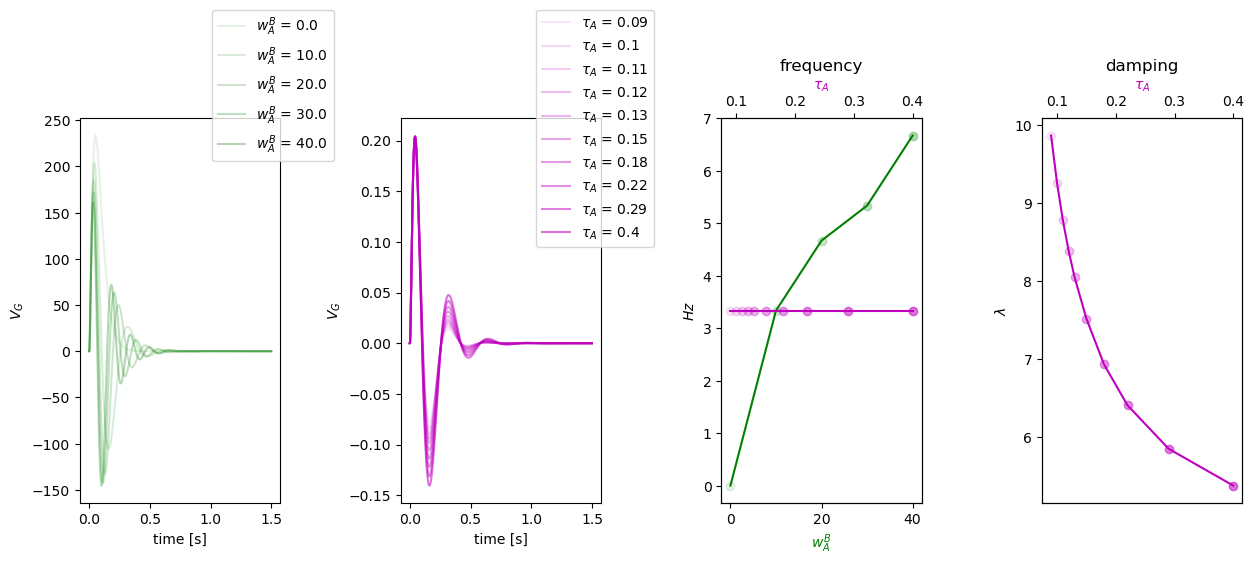

In [30]:
fig = plt.figure(figsize = (15,5))

gs = fig.add_gridspec(1,4)

ax0w = fig.add_subplot(gs[0,0])
ax0t = fig.add_subplot(gs[0,1])
ax1 = fig.add_subplot(gs[0,3])
ax1t = ax1.twiny()
ax2 = fig.add_subplot(gs[0,2])
ax2t = ax2.twiny()

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)


for i,val in enumerate(vals_w): 

    x = val

    ax0w.plot(time_impulse, signal_w[i], label = f'{wstring} = {val}', color = 'g', alpha = i*0.05+0.1)


    ax1.scatter(val,damp_w[i], zorder = 10, color = 'g', alpha = i*0.05+0.1)
    ax2.scatter(val,freq_w[i], zorder = 10, color = 'g', alpha = i*0.05+0.1)


for i,val in enumerate(vals_tauA): 
    x = val
 

    ax0t.plot(time_impulse, signal_tau[i], label = f'{tstring} = {np.round(val,2)}', color = 'm', alpha = i*0.05+0.1)

 
    ax1t.scatter(val,damp_tau[i], zorder = 10, color = 'm', alpha = i*0.05+0.1)
    ax2t.scatter(val,freq_tau[i], zorder = 10, color = 'm', alpha = i*0.05+0.1)


ax1t.plot(vals_tauA,damp_tau, color = 'm')
# ax1t.plot(vals_tauA,calculate_damping(vals_tauA,tauB), color = 'm')
ax2t.plot(vals_tauA,freq_tau, color = 'm')

ax1.plot(vals_w,damp_w, color = 'g')
ax2.plot(vals_w,freq_w, color = 'g')
  
  
ax0w.set_xlabel('time [s]')
ax0w.set_ylabel('$V_{G}$')
# ax0w.set_title('impulse response')

ax0t.set_xlabel('time [s]')
ax0t.set_ylabel('$V_{G}$')
# ax0t.set_title('impulse response')


ax1.set_xlabel(f'')
ax1.set_xticks([])
ax1t.set_xlabel(f'{tstring}',color = 'm')
ax1.set_ylabel('$\lambda$')
ax1.set_title('damping')


ax2.set_xlabel(f'{wstring}', color = 'g')
ax2t.set_xlabel(f'{tstring}', color = 'm')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

ax0t.legend(loc = 'upper right', bbox_to_anchor = (1.3,1.3))
ax0w.legend(loc = 'upper right', bbox_to_anchor = (1.3,1.3))

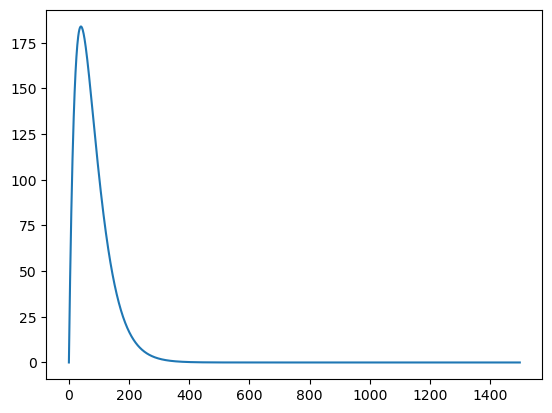

In [39]:
plt.plot(out_impulse['inp'])

<>:46: SyntaxWarning: invalid escape sequence '\ '
<>:46: SyntaxWarning: invalid escape sequence '\ '
/var/folders/mz/v_y_dj556cs59qdf5qbn5tbc0000gn/T/ipykernel_71837/3655506691.py:46: SyntaxWarning: invalid escape sequence '\ '
  ax2.set_ylabel('$|V_{min}|$ \ $|V_{max}|$')


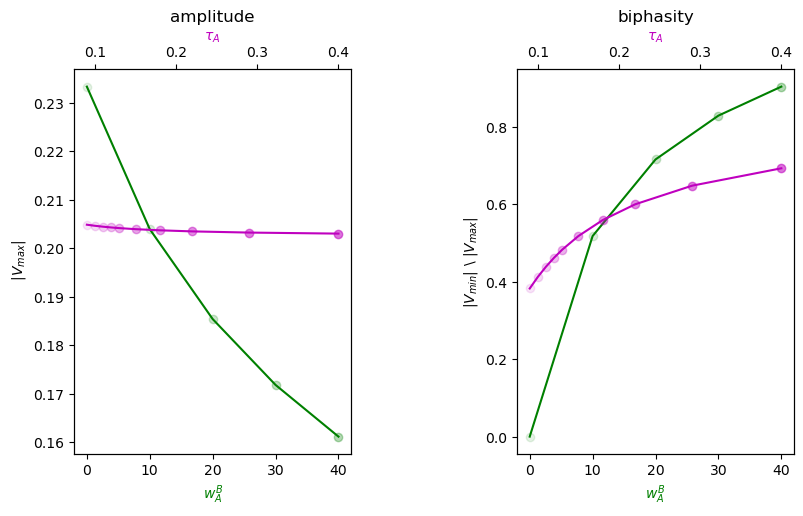

In [15]:
fig = plt.figure(figsize = (15,5))

gs = fig.add_gridspec(1,3)


ax1 = fig.add_subplot(gs[0,0])
ax1t = ax1.twiny()
ax2 = fig.add_subplot(gs[0,1])
ax2t = ax2.twiny()


fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)


for i,val in enumerate(vals_w): 

    x = val
    ax1.scatter(val,amp_w[i], zorder = 10, color = 'g', alpha = i*0.05+0.1)
    ax2.scatter(val,bif_w[i], zorder = 10, color = 'g', alpha = i*0.05+0.1)


for i,val in enumerate(vals_tauA): 
    
    x = val
    ax1t.scatter(val,amp_tau[i], zorder = 10, color = 'm', alpha = i*0.05+0.1)
    ax2t.scatter(val,bif_tau[i], zorder = 10, color = 'm', alpha = i*0.05+0.1)


ax1t.plot(vals_tauA,amp_tau, color = 'm')
ax2t.plot(vals_tauA,bif_tau, color = 'm')

ax1.plot(vals_w,amp_w, color = 'g')
ax2.plot(vals_w,bif_w, color ='g')
  


ax1.set_xlabel(f'{wstring}', color = 'g')
ax1t.set_xlabel(f'{tstring}',color = 'm')
ax1.set_ylabel(' $|V_{max}|$')
ax1.set_title('amplitude')


ax2.set_xlabel(f'{wstring}', color = 'g')
ax2t.set_xlabel(f'{tstring}', color = 'm')
ax2.set_ylabel('$|V_{min}|$ \ $|V_{max}|$')
ax2.set_title('biphasity')

ax0t.legend(loc = 'upper right', bbox_to_anchor = (1.3,1.3))
ax0w.legend(loc = 'upper right', bbox_to_anchor = (1.3,1.3))